# Needed Data to run simulation

In [1]:
import pandapower as pp #import pandapower
import pandas as pd
import math
import random
import pandapower.networks as nw
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import warnings
import statsmodels.api as sm
from scipy.stats import truncnorm
from datetime import datetime

# Path to your Excel file
file_path = 'Profiles.xlsx'

# Read the Excel file into a DataFrame
PV_profile = pd.read_excel(file_path,index_col=0, sheet_name='PVs_ROOFTOPS') # 24 hour per kw historical rooftop production for different months 

# Load .npy data from file
file_path = 'Data House - 30 mins resolution.npy'  # A lot of load profiles from nandos (Australia)
load_profile = np.load(file_path)


file_path = 'annual_consumption_profiles_cyprus.npy'  # A lot of load profiles from nandos (Australia)
load_profile_cyprus=np.load(file_path)
load_profile_cyprus=load_profile_cyprus/1000

# Path to your Excel file
file_path = 'Mean_July_Load_Profile.xlsx'

# Read the Excel file into a DataFrame
Strovolides_Loads_Measurement = pd.read_excel(file_path,index_col=0)
Strovolides_Loads_Measurement.index = pd.to_datetime(Strovolides_Loads_Measurement.index)
# Strovolides_Loads_Measurement = Strovolides_Loads_Measurement.resample('30T').max()
Strovolides_Loads_Measurement.index=Strovolides_Loads_Measurement.index.time

# Load the Excel file
file_path = 'Thesis_Data.xlsx' 

# Read the 'Departure' and 'Arrival' sheets, ignoring the first row
departure = pd.read_excel(file_path, sheet_name='Departure', skiprows=1)
arrival = pd.read_excel(file_path, sheet_name='Arrival', skiprows=1)
distance = pd.read_excel(file_path, sheet_name='Distance', skiprows=1)

# Read the specified sheet into a DataFrame
PV_Data = pd.read_excel('NET_METERING_Cleaned.xlsx')

# Drop rows where 'Power' or 'Phase' columns have NaN values
PV_Data = PV_Data.dropna(subset=['Power', 'Phase'])

############--------------------------------------- For Arrival t-student -------------------------------------#########################
# Fit the Student's t-distribution to the data
df, loc_arrival, scale_arrival = stats.t.fit(arrival)
# Parameters for truncation
a, b = 0, 23  # Truncation limits

# Standardize the limits for truncnorm
a_std = (a - loc_arrival) / scale_arrival
b_std = (b - loc_arrival) / scale_arrival

# Create the truncated normal distribution
truncated_normal_arrival = stats.truncnorm(a_std, b_std, loc=loc_arrival, scale=scale_arrival)

############--------------------------------------- Distance for Weekdays Probabilities Selection using Histogram method -------------------------------------#########################

# Step 1: Count the frequency of each unique value
value_counts_weekdays = pd.Series(distance.iloc[:,0][distance.iloc[:,0]<300]).value_counts()

# Step 2: Calculate probabilities
values_weekdays = value_counts_weekdays.index  # Unique values
probabilities_weekdays = value_counts_weekdays / value_counts_weekdays.sum()  # Normalize counts to probabilities

# random_value = np.random.choice(values_weekdays, p=probabilities_weekdays)

############--------------------------------------- Distance for Weekends, Probabilities Selection using Histogram method -------------------------------------#########################

# Step 1: Count the frequency of each unique value
value_counts_weekends = pd.Series(distance.iloc[:,1][distance.iloc[:,1]<300]).value_counts()

# Step 2: Calculate probabilities
values_weekends = value_counts_weekends.index  # Unique values
probabilities_weekends = value_counts_weekends / value_counts_weekends.sum()  # Normalize counts to probabilities

# random_value = np.random.choice(values_weekends, p=probabilities_weekends)

######################---------------- For Arrival and Departure Normal Distribution -----------------------------------################################## 

# Step 1: Calculate mean and standard deviation
mean_arrival = arrival.mean()
std_dev_arrival = arrival.std()
# print("the Mean value for arrival are " + str(mean_arrival.item()))
# print("the Std value for arrival are " + str(std_dev_arrival.item()))

mean_departure = departure.mean()
std_dev_departure = departure.std()
# print("the Mean value for departure are " + str(mean_departure.item()))
# print("the Std value for departure are " + str(std_dev_departure.item()))

# Step 2: Create the normal distribution
normal_dist_arrival = norm(loc=mean_arrival, scale=std_dev_arrival)
normal_dist_departure = norm(loc=mean_departure, scale=std_dev_departure)

######################---------------- For Distance Normal Distribution -----------------------------------################################## 

# Step 1: Calculate mean and standard deviation
mean_distance_wd = distance.iloc[:,0].mean()
std_dev_distance_wd = distance.iloc[:,0].std()
# print("the Mean value for weekdays distance are " + str(mean_distance_wd))
# print("the Std value for weekdays distance are " + str(std_dev_distance_wd))

mean_distance_wk = distance.iloc[:,1].mean()
std_dev_distance_wk = distance.iloc[:,1].std()
# print("the Mean value for weekends distance are " + str(mean_distance_wk))
# print("the Std value for weekends distance are are " + str(std_dev_distance_wk))

# Step 2: Create the normal distribution
normal_dist_distance_wd = norm(loc=mean_distance_wd, scale=std_dev_distance_wd)
normal_dist_distance_wk = norm(loc=mean_distance_wk, scale=std_dev_distance_wk)


############---------------- Truncate Normal Distribution for Arrival and Departure -------------------------###################################

# Set bound to the distribution
a, b = (0 - mean_arrival.item()) / std_dev_arrival.item(), (23 - mean_arrival.item()) / std_dev_arrival.item()
# truncated_normal_arrival = truncnorm(a, b, loc=mean_arrival.item(), scale=std_dev_arrival.item())

c, d = (0 - mean_departure.item()) / std_dev_departure.item(), (23 - mean_departure.item()) / std_dev_departure.item()
truncated_normal_departure = truncnorm(c, d, loc=mean_departure.item(), scale=std_dev_departure.item())


################## ------------- PV power for 1-phase and 3-phase with Probabilities Selection using Histogram method ------------------- ##########################

one_phase_power = PV_Data[PV_Data['Phase'] != '3Φ']['Power']
one_phase_power = pd.to_numeric(one_phase_power, errors='coerce')
one_phase_power.dropna(inplace=True)
one_phase_power[one_phase_power > 500] = one_phase_power[one_phase_power>500]/1000
one_phase_power = one_phase_power[one_phase_power <= 4.2]

# Step 1: Count the frequency of each unique value
value_counts_one_phase = pd.Series(one_phase_power).value_counts()

# Step 2: Calculate probabilities
values_one_phase = value_counts_one_phase.index  # Unique values
probabilities_one_phase = value_counts_one_phase / value_counts_one_phase.sum()  # Normalize counts to probabilities

# Step 3: Randomly select a value based on probabilities
# random_value = np.random.choice(values_one_phase, p=probabilities_one_phase)

three_phase_power = PV_Data[PV_Data['Phase'] == '3Φ']['Power']
three_phase_power = pd.to_numeric(three_phase_power, errors='coerce')
three_phase_power.dropna(inplace=True)
three_phase_power[three_phase_power > 500] = three_phase_power[three_phase_power>500]/1000
three_phase_power = three_phase_power[three_phase_power <= 10.4]

# Step 1: Count the frequency of each unique value
value_counts_three_phase = pd.Series(three_phase_power).value_counts()

# Step 2: Calculate probabilities
values_three_phase = value_counts_three_phase.index  # Unique values
probabilities_three_phase = value_counts_three_phase / value_counts_three_phase.sum()  # Normalize counts to probabilities

PV_Proba = [{
    "values_one_phase": values_one_phase,
    "probabilities_one_phase": probabilities_one_phase,
    "values_three_phase": values_three_phase,
    "probabilities_three_phase": probabilities_three_phase
}]
# Step 3: Randomly select a value based on probabilities
# random_value = np.random.choice(values_three_phase, p=probabilities_three_phase)



C:\Users\savva\AppData\Local\Temp\ipykernel_15784\2739327659.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Strovolides_Loads_Measurement.index = pd.to_datetime(Strovolides_Loads_Measurement.index)


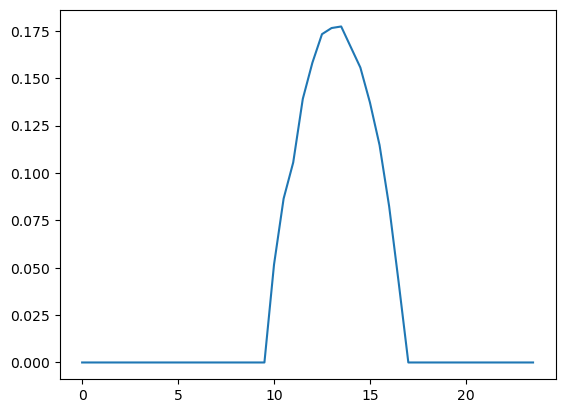

In [8]:
# Define a function to calculate cos(phi) based on the PV profile value
def calculate_cos_phi(P):
    if P < 0.4:
        return 1.0
    elif 0.4 <= P <= 1.0:
        return -1/6 * P + 1.0667
    else:
        raise ValueError("P should be in the range 0 to 1")

# Apply the function to each value in the PV profile
cos_phi_values = [calculate_cos_phi(P) for P in PV_profile.iloc[:,12]]

# Calculate tan(phi) values
tan_phi_values = [np.sqrt(1 - cos_phi**2) / cos_phi if cos_phi != 0 else np.nan for cos_phi in cos_phi_values]

# Calculate Q_PV_profile (reactive power based on tan(phi) and PV active power)
Q_PV_profile = PV_profile.iloc[:,12] * tan_phi_values

# plt.plot(np.arange(0, 24, 0.5),Q_PV_profile)


In [ ]:
# Define the cos(φ) linear dependence function for P > 0.4
def calculate_cos_phi(p):
    if p <= 0.4:
        return 1.0  # cos(φ) = 1 below P = 0.4
    else:
        return 1.0 - 0.1 * (p - 0.4) / (1.0 - 0.4)  # Linear reduction to 0.9 at P = 1

# Compute Q profile
def calculate_q_profile(pv_profile):
    q_profile = pd.DataFrame(index=pv_profile.index, columns=pv_profile.columns)
    
    for column in pv_profile.columns:
        p_values = pv_profile[column]
        q_values = []
        
        for p in p_values:
            cos_phi = calculate_cos_phi(p)  # Calculate cos(φ)
            phi = np.arccos(cos_phi)        # Calculate φ (angle in radians)
            q = p * np.tan(phi)             # Calculate Q
            q_values.append(q)
        
        q_profile[column] = q_values
    
    return q_profile

# Calculate the Q profile
q_profile = calculate_q_profile(PV_profile)




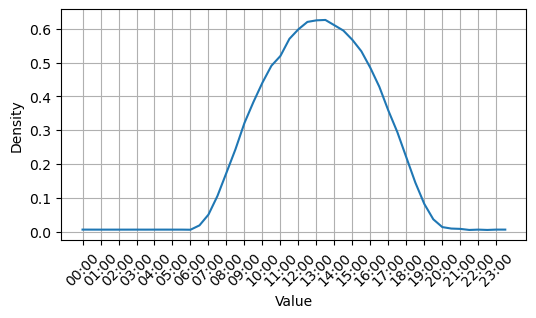

In [ ]:
# # Plot histogram of the data
# plt.figure(figsize=(6, 3))
# # Generate time labels for 30-minute intervals (00:00, 00:30, ..., 23:30)
# time_labels = [f'{hour:02d}:{minute:02d}' for hour in range(24) for minute in [0, 30]]

# plt.plot(range(1, len(PV_profile.iloc[:, 12]) + 1), PV_profile.iloc[:, 12])
# plt.xticks(range(1, len(time_labels) + 1, 2), time_labels[::2], rotation=45)



# # plt.title('Fitting Student\'s t-Distribution to Data')
# plt.xlabel('Value')
# plt.ylabel('Density')
# # plt.legend()
# plt.grid()
# plt.show()

# # Export the data to a file
# with open("One_Phase_PV_histogram_data.txt", "w") as f:
#     for x, y in zip(time_labels, PV_profile.iloc[:, 12]):
#         f.write(f"{x} {y}\n")


